# Take a look at your dataset

In [1]:
!pip install torch-geometric
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 KB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=1543cc82b4177cb571fdd8d9037a39671309cf911d43132376888bec5669f7aa
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 23.1 MB/s eta 0:00:00


In [1]:
!python -c "import torch; print('PyTorch:',torch.__version__)"
!python -c "import torch; print('torch CUDA:',torch.version.cuda)"
!python -c "import torch_geometric; print('PyG (PyTorch Geometric):',torch_geometric.__version__)"
!python --version
# !nvidia-smi

PyTorch: 2.0.0+cu118
torch CUDA: 11.8
PyG (PyTorch Geometric): 2.3.0
Python 3.9.16


In [2]:
import sys
import os
import os.path as osp
import random

import numpy as np
import pandas as pd
from torch_geometric.datasets import MoleculeNet, MovieLens
from torch_geometric.data import Dataset, Data, download_url
from torch_geometric.utils import negative_sampling, convert, to_dense_adj
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.nn.conv import MessagePassing
import torch

from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
# TODO: Choose a dataset from MoleculeNet or MovieLens
# i chose BACE from MoleculeNet
data = MoleculeNet(root=".", name="BACE")
data


Processing...
Done!


BACE(1513)

In [107]:
# Investigating the dataset
print("Dataset type: ", type(data))
  ############# Your code here ############
def Information_Extaction(data):
  print('There is %d graph in the data.' %len(data))
  print('The graph has %d nodes.' %data[0].num_nodes)
  print('The graph has %d edges.' %data[0].num_edges)
  print('Each node has {} features.'.format(data[0].num_node_features))
  print("The Average degree for each node is %d." %round((data[0].num_edges) / (data[0].num_nodes),4))
  return
Information_Extaction(data)
  #########################################

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
There is 1513 graph in the data.
The graph has 32 nodes.
The graph has 70 edges.
Each node has 9 features.
The Average degree for each node is 2.


In [108]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
display(data[0].x)

tensor([[8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [6, 1, 4, 5, 1, 0, 4, 0, 1],
        [7, 0, 3, 5, 1, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 0, 0],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 1, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 2, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 3, 5, 2, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
 

In [109]:
# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 0, 29],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 3, 28],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 5,  7],
        [ 6,  5],
        [ 7,  5],
        [ 7,  8],
        [ 7, 27],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 18],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 16],
        [12, 11],
        [12, 13],
        [13, 12],
        [13, 14],
        [13, 20],
        [14, 13],
        [14, 15],
        [15, 14],
        [15, 16],
        [16, 11],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18,  9],
        [18, 17],
        [18, 19],
        [19, 18],
        [20, 13],
        [20, 21],
        [20, 25],
        [21, 20],
        [21, 22],
        [22, 21],
        [22, 23],
        [23, 22],
        [23, 24],
        [2

##lets see the graph

In [10]:
def visualize_graph(graph, figsize=32):
  plt.figure(figsize=(figsize,figsize))
  plt.xticks([])
  plt.yticks([])
  plt.title('Graph Visualization')
  graph = to_networkx(graph, to_undirected=True)
  nx.draw(graph)
  plt.show()

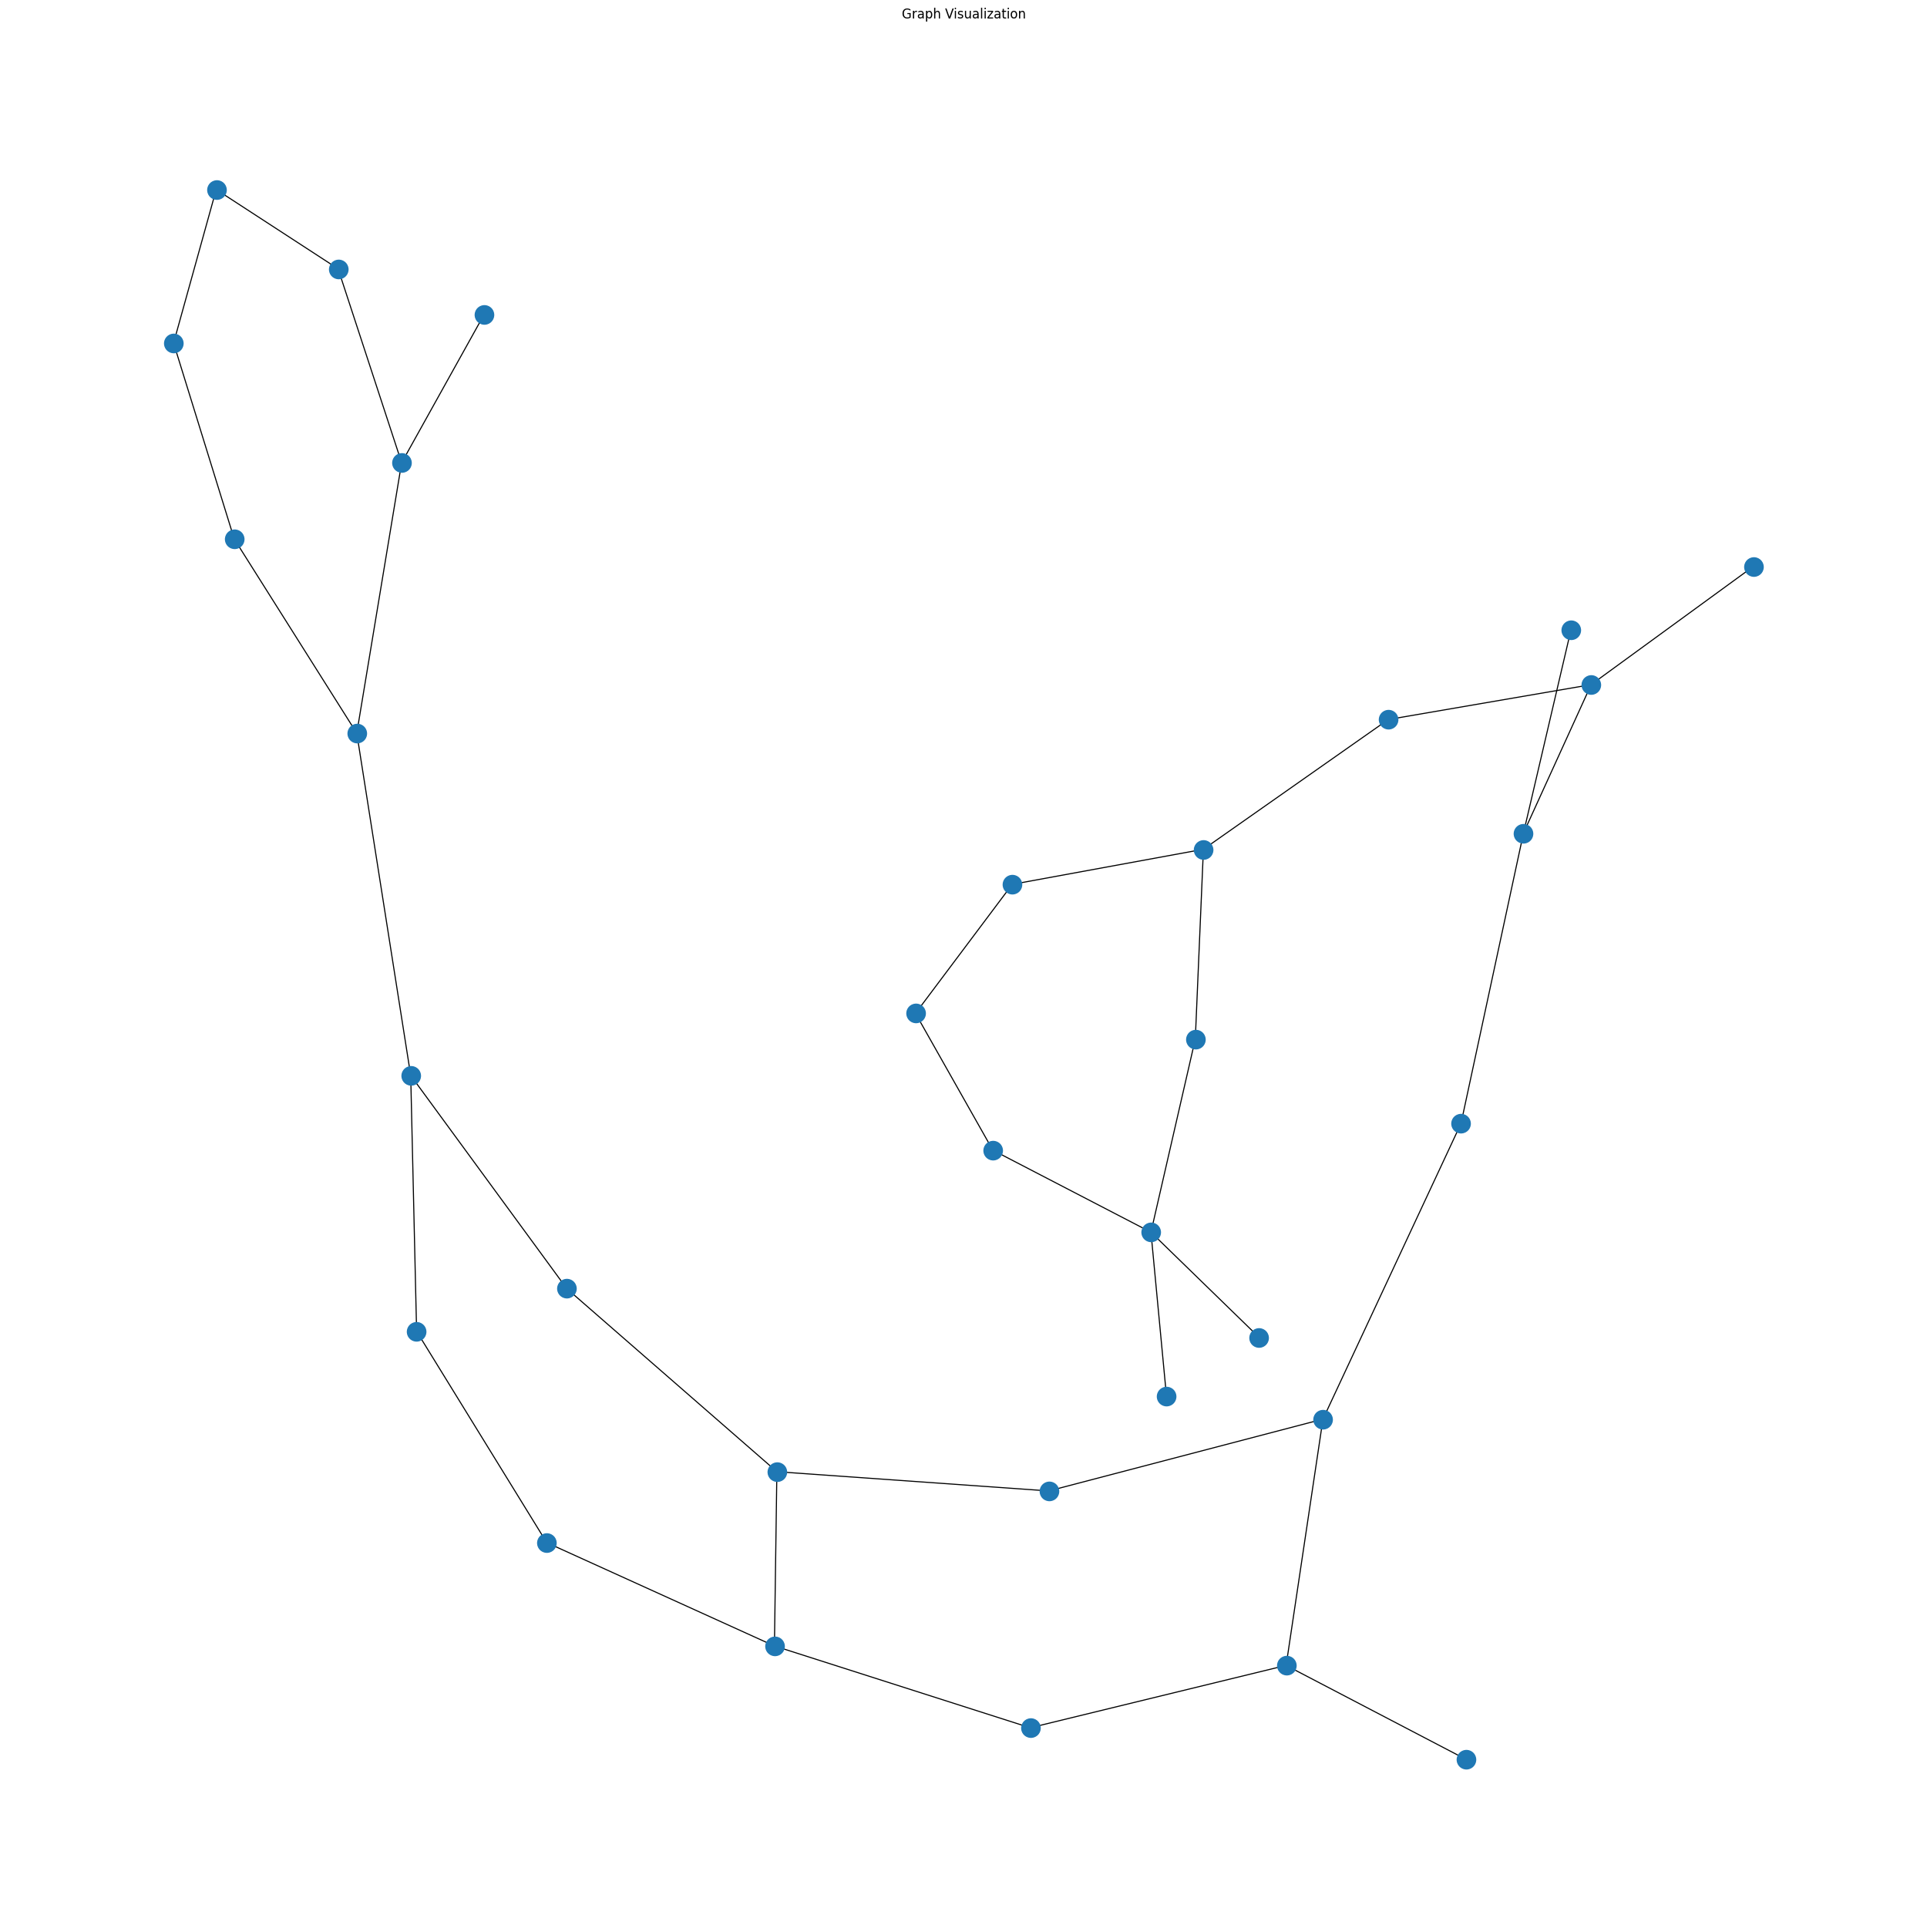

In [12]:
visualize_graph(data[0])

# Creating your own Dataset:

In [56]:
from rdkit import Chem
class MyOwnDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return 'bace.csv'

    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        return [f'data_test_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
      self.data = pd.read_csv(self.raw_paths[0])
      for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["mol"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        moles=mol["mol"]
                        ) 

            torch.save(data, 
                os.path.join(self.processed_dir, 
                             f'data_{index}.pt'))
      

    def _get_node_features(self, mol):

        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):

        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [57]:
mydataset = MyOwnDataset(root = "/content")

Processing...
100%|██████████| 1513/1513 [00:03<00:00, 405.35it/s]
Done!


##checking my own dataset 

In [58]:
mydataset[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 5,  7],
        [ 7,  5],
        [ 7,  8],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [12, 13],
        [13, 12],
        [13, 14],
        [14, 13],
        [14, 15],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 18],
        [13, 20],
        [20, 13],
        [20, 21],
        [21, 20],
        [21, 22],
        [22, 21],
        [22, 23],
        [23, 22],
        [23, 24],
        [24, 23],
        [24, 25],
        [25, 24],
        [25, 26],
        [26, 25],
        [ 7, 27],
        [27,  7],
        [ 3, 28],
        [2

In [59]:
mydataset[0].x

tensor([[8., 2., 0., 4., 0., 0., 0., 1., 0.],
        [6., 2., 0., 4., 0., 2., 0., 1., 0.],
        [6., 2., 0., 4., 0., 2., 0., 1., 0.],
        [6., 3., 0., 4., 0., 1., 0., 1., 1.],
        [7., 2., 0., 3., 0., 1., 0., 0., 0.],
        [6., 3., 0., 3., 0., 0., 0., 0., 0.],
        [8., 1., 0., 3., 0., 0., 0., 0., 0.],
        [6., 3., 0., 4., 0., 1., 0., 0., 1.],
        [6., 2., 0., 4., 0., 2., 0., 0., 0.],
        [6., 3., 0., 3., 1., 0., 0., 1., 0.],
        [6., 2., 0., 3., 1., 1., 0., 1., 0.],
        [6., 3., 0., 3., 1., 0., 0., 1., 0.],
        [6., 2., 0., 3., 1., 1., 0., 1., 0.],
        [6., 3., 0., 3., 1., 0., 0., 1., 0.],
        [6., 2., 0., 3., 1., 1., 0., 1., 0.],
        [6., 2., 0., 3., 1., 1., 0., 1., 0.],
        [6., 3., 0., 3., 1., 0., 0., 1., 0.],
        [7., 2., 0., 3., 1., 0., 0., 1., 0.],
        [6., 3., 0., 3., 1., 0., 0., 1., 0.],
        [7., 1., 0., 3., 0., 2., 0., 0., 0.],
        [6., 3., 0., 3., 1., 0., 0., 1., 0.],
        [6., 2., 0., 3., 1., 1., 0

In [118]:
Information_Extaction(mydataset)

There is 1513 graph in the data.
The graph has 32 nodes.
The graph has 70 edges.
Each node has 9 features.
The Average degree for each node is 2.


###finding induced subgraph

In [117]:
import torch_geometric
#find node degrees
node_deg = torch_geometric.utils.degree(data[0].edge_index[0])
#find mean of node degrees
mean_deg = node_deg.mean()
#find the indexes with degree more than mean
mask = node_deg > mean_deg
subset=[]
for i in range(len(mask)):
  if mask[i]:
    subset.append(i)
#find induced subgraph with than nodes
ind_data = data[0].subgraph(torch.tensor(subset))

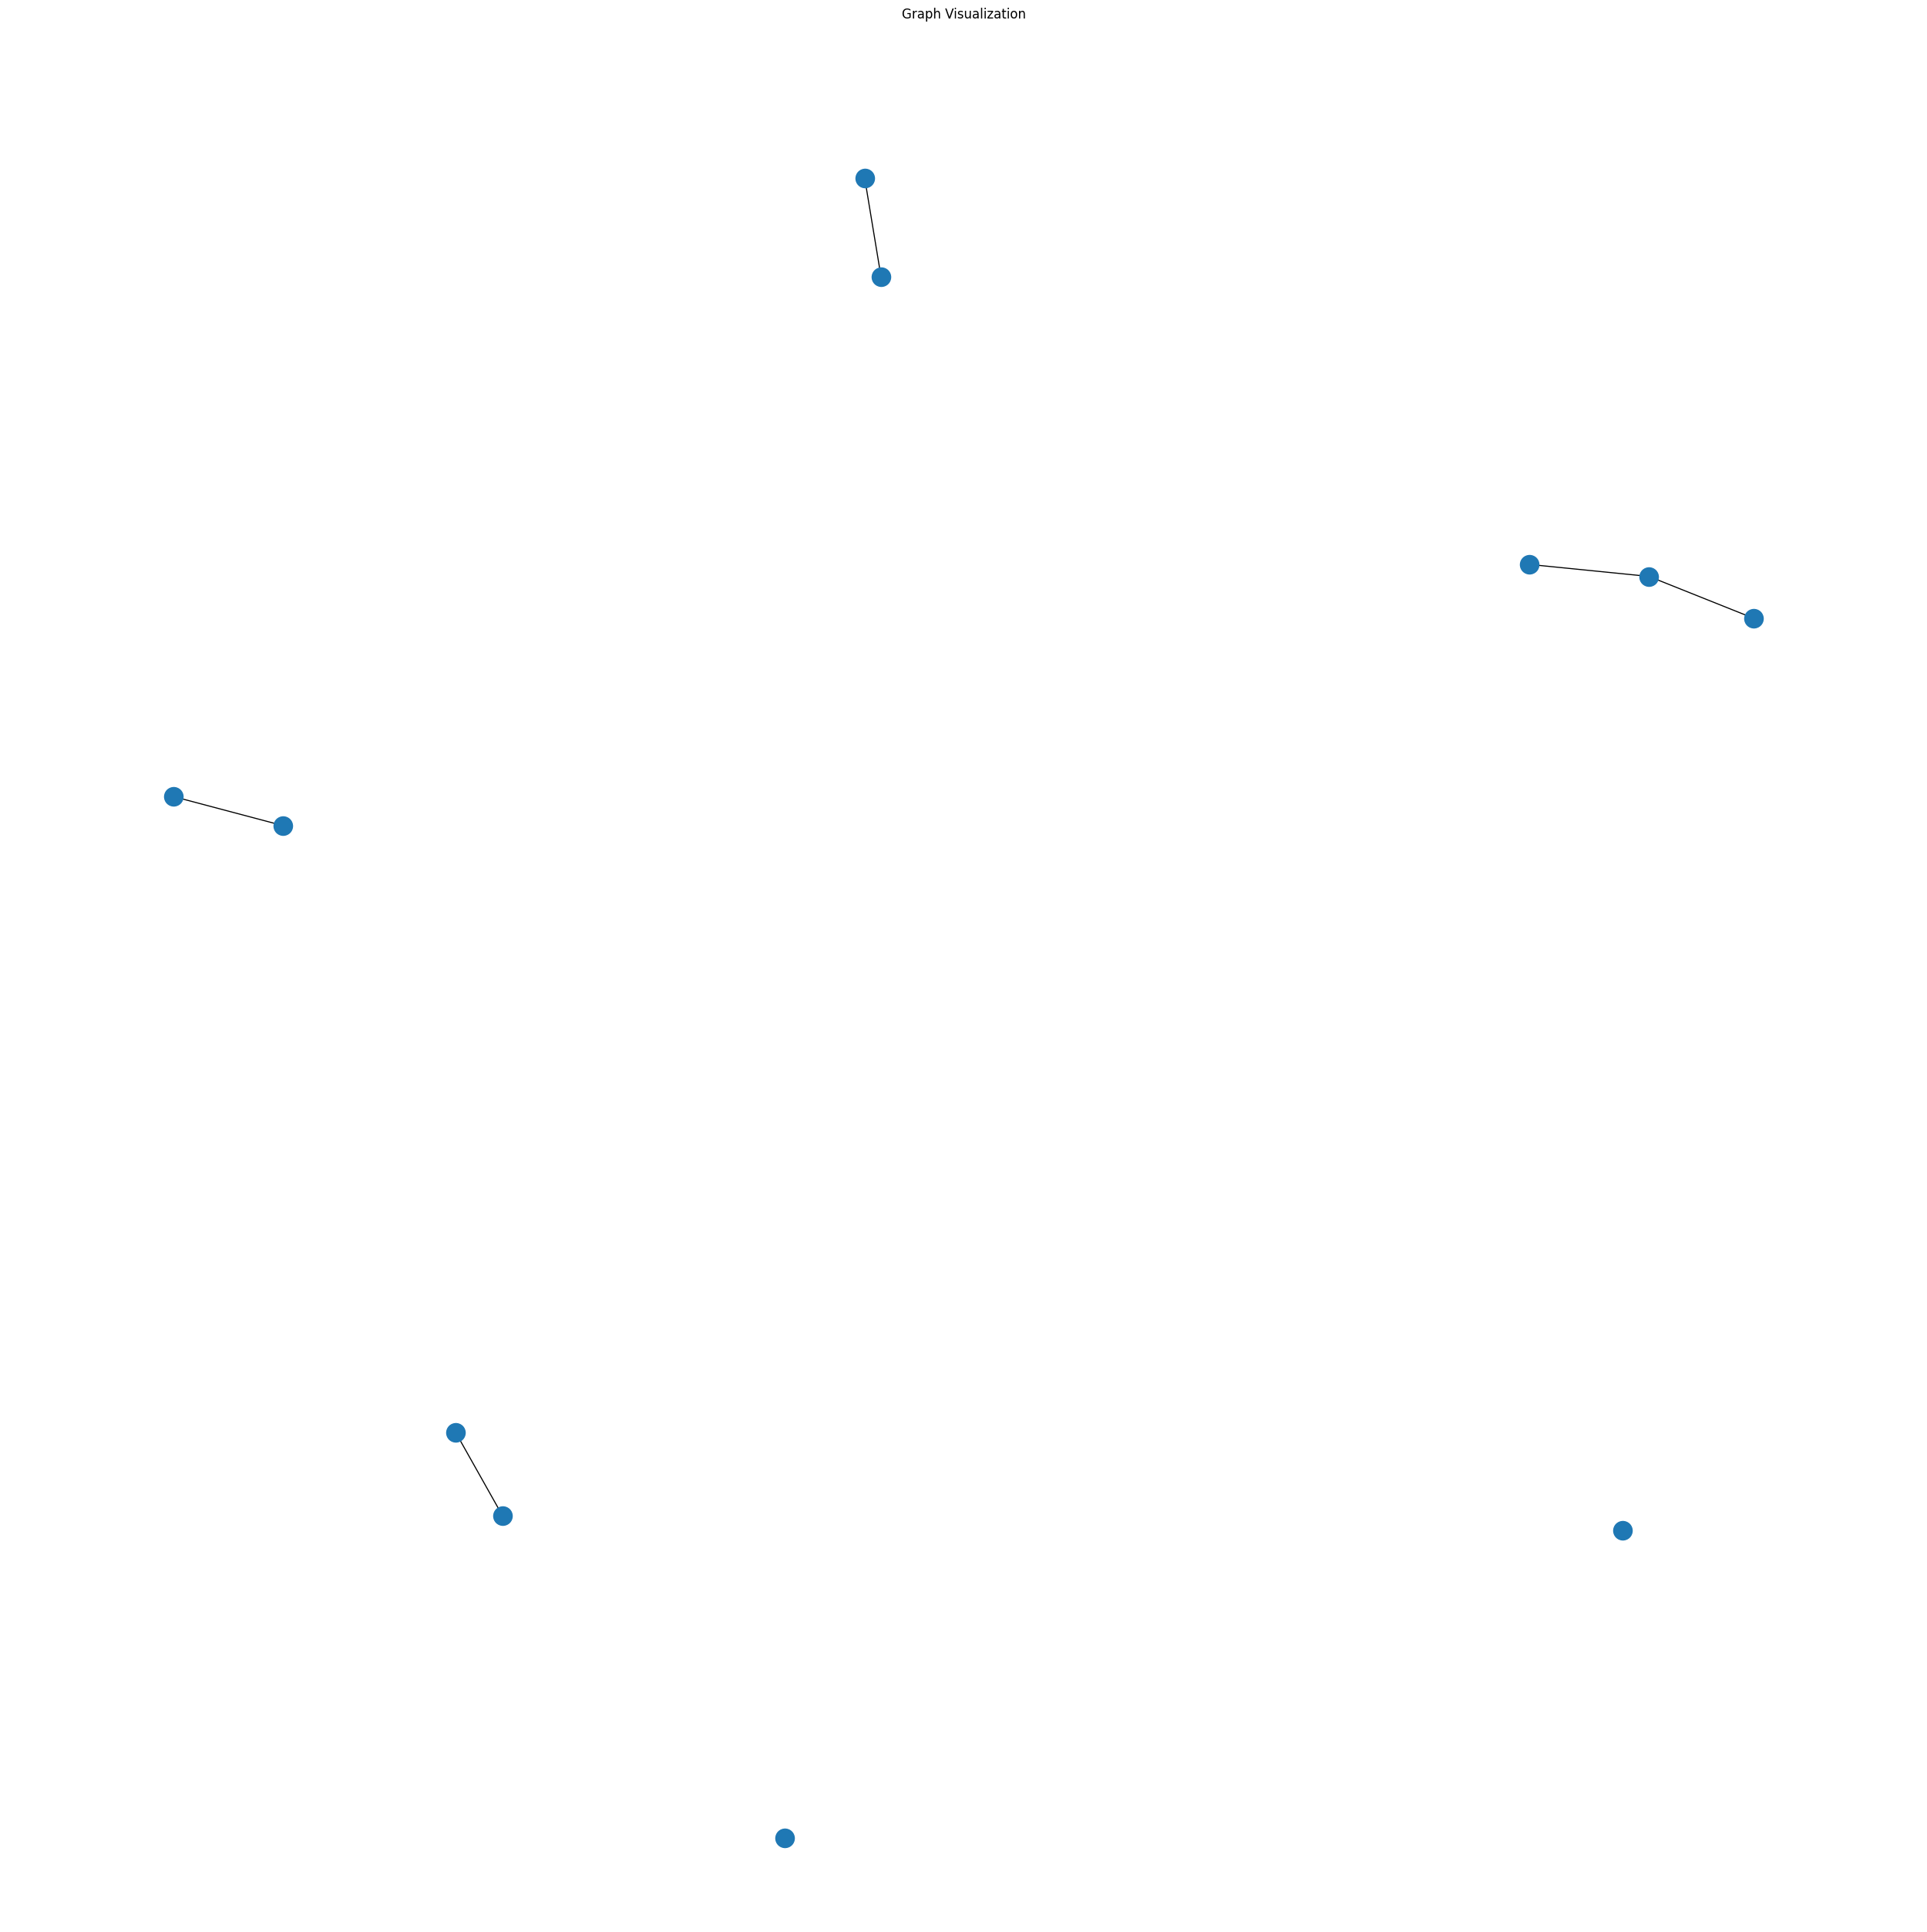

In [116]:
visualize_graph(ind_data)